In [1]:
%load_ext autoreload
%autoreload 2

In [338]:
from nlmk.dataset import Dataset

import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from collections import Counter

In [3]:
RULONI_PATH = "../data/Ruloni.csv"
VALKI_PATH = "../data/Valki.csv"
ZAVALKI_PATH = "../data/Zavalki.csv"
TEST_PATH = "../data/Test.csv"

In [288]:
ds = Dataset(RULONI_PATH, VALKI_PATH, ZAVALKI_PATH, TEST_PATH)

100%|██████████| 269967/269967 [00:02<00:00, 102835.98it/s]


In [315]:
train_X, train_y, valid_X, valid_y = ds.get_train_valid_data()

In [290]:
train_X.head()

,номер_клетки,положение_в_клети,номер_валка,продолжительность_завалки_мин,день_недели,час,материал_валка,сум_Масса,мин_Масса,макс_Масса,...,мин_Толщина,макс_Толщина,мед_Толщина,ср_Толщина,сум_Ширина,мин_Ширина,макс_Ширина,мед_Ширина,ср_Ширина,число_рулонов
0,8,1,222,197,0,0,6,2482.95,9.92,31.34,...,1.85,5.0,2.5,3.000442,144350,925,1450,1358.0,1277.433628,113
1,8,0,260,197,0,0,1,2482.95,9.92,31.34,...,1.85,5.0,2.5,3.000442,144350,925,1450,1358.0,1277.433628,113
2,9,1,410,197,0,0,2,2482.95,9.92,31.34,...,1.85,5.0,2.5,3.000442,144350,925,1450,1358.0,1277.433628,113
3,9,0,57,197,0,0,1,2482.95,9.92,31.34,...,1.85,5.0,2.5,3.000442,144350,925,1450,1358.0,1277.433628,113
4,10,1,273,197,0,0,15,2482.95,9.92,31.34,...,1.85,5.0,2.5,3.000442,144350,925,1450,1358.0,1277.433628,113


In [291]:
def add_del(model, train_X, train_y, valid_X, valid_y):
    features_all = set(train_X.columns)
    features = set()
    feature_sets = []
    
    last_train_score = np.inf
    last_valid_score = np.inf
    
    while True:
        feature, train_score, valid_score = add_one(model, train_X, train_y, valid_X, valid_y, features)
        if valid_score < last_valid_score and not feature.startswith("rnd_"):
            features = features.union({feature})
            feature_sets.append(features)
            last_valid_score = valid_score
            print("ADD", feature, "TRAIN SCORE", train_score, "VALID SCORE", valid_score)
        else:
            break
    
    while True:
        feature, train_score, valid_score = del_one(model, train_X, train_y, valid_X, valid_y, features)
        if valid_score < last_valid_score and not feature.startswith("rnd_"):
            features = features - {feature}
            feature_sets.append(features)
            last_valid_score = valid_score
            print("DEL", feature, "TRAIN SCORE", train_score, "VALID SCORE", valid_score)
        else:
            break
    
    return features

def add_one(model, train_X, train_y, valid_X, valid_y, features):
    features_all = set(train_X.columns)
    features_unused = features_all - features
    
    scores = {}
    for feature in features_unused:
        features_new = list(features.union({feature}))
        
        train_X_new = train_X[features_new]
        valid_X_new = valid_X[features_new]
        
        model.fit(
            train_X_new, train_y, 
              eval_set=[(train_X_new, train_y), (valid_X_new, valid_y)],
            verbose=False
        )
        
        idx = np.argmin(model.evals_result()["validation_1"]["rmse"])
        train_score = model.evals_result()["validation_0"]["rmse"][idx]
        valid_score = model.evals_result()["validation_1"]["rmse"][idx]
        
        scores[feature] = train_score, valid_score
    
    best_feature, (train_score, valid_score) = min(scores.items(), key=lambda x: x[1][1])
    return best_feature, train_score, valid_score

def del_one(model, train_X, train_y, valid_X, valid_y, features):
    scores = {}
    for feature in features:
        features_new = list(features - {feature})
        
        train_X_new = train_X[features_new]
        valid_X_new = valid_X[features_new]
        
        model.fit(
            train_X_new, train_y, 
            eval_set=[(train_X_new, train_y), (valid_X_new, valid_y)], 
            verbose=False
        )
        
        idx = np.argmin(model.evals_result()["validation_1"]["rmse"])
        train_score = model.evals_result()["validation_0"]["rmse"][idx]
        valid_score = model.evals_result()["validation_1"]["rmse"][idx]
        
        scores[feature] = train_score, valid_score
    
    best_feature, (train_score, valid_score) = min(scores.items(), key=lambda x: x[1][1])
    return best_feature, train_score, valid_score

def add_noisy_features(X, factor=1):
    features_all = set(X.columns)
    idx = np.arange(len(X))
    
    for _ in range(factor):
        for feature in features_all:
            np.random.shuffle(idx)
            X["rnd_" + feature] = X[feature].values[idx]
    
    return X

In [292]:
train_X = add_noisy_features(train_X)
valid_X = add_noisy_features(valid_X)

In [293]:
model = xgb.XGBRegressor(
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=1000, 
    verbosity=0, 
    objective="reg:squarederror", 
    n_jobs=4,
)

In [294]:
features = add_del(model, train_X, train_y, valid_X, valid_y)

ADD номер_клетки TRAIN SCORE 0.316065 VALID SCORE 0.366324
ADD продолжительность_завалки_мин TRAIN SCORE 0.296679 VALID SCORE 0.348951
ADD мин_Толщина TRAIN SCORE 0.281343 VALID SCORE 0.339854
ADD материал_валка TRAIN SCORE 0.272689 VALID SCORE 0.332375
ADD ср_Толщина TRAIN SCORE 0.265442 VALID SCORE 0.327811
ADD мед_Ширина TRAIN SCORE 0.261869 VALID SCORE 0.325548
ADD ср_Ширина TRAIN SCORE 0.259023 VALID SCORE 0.323611
ADD мин_Ширина TRAIN SCORE 0.25756 VALID SCORE 0.322644
ADD макс_Толщина TRAIN SCORE 0.25673 VALID SCORE 0.322232


In [296]:
features = list(features)

In [297]:
features

['макс_Толщина',
 'продолжительность_завалки_мин',
 'мин_Толщина',
 'ср_Ширина',
 'материал_валка',
 'номер_клетки',
 'ср_Толщина',
 'мин_Ширина',
 'мед_Ширина']

In [316]:
model = xgb.XGBRegressor(
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=1000, 
    verbosity=0, 
    objective="reg:squarederror", 
    n_jobs=4,
)

In [317]:
model.fit(
    train_X[features], train_y, 
    eval_set=[(train_X[features], train_y), (valid_X[features], valid_y)],
    verbose=False
)

/home/ivb/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

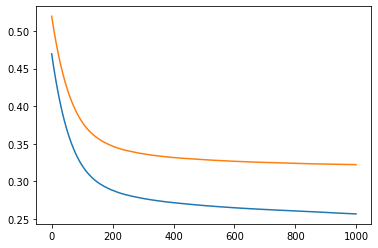

In [318]:
plt.plot(model.evals_result()["validation_0"]["rmse"])
plt.plot(model.evals_result()["validation_1"]["rmse"])

In [319]:
np.argmin(model.evals_result()["validation_1"]["rmse"]), min(model.evals_result()["validation_1"]["rmse"])

(999, 0.322232)

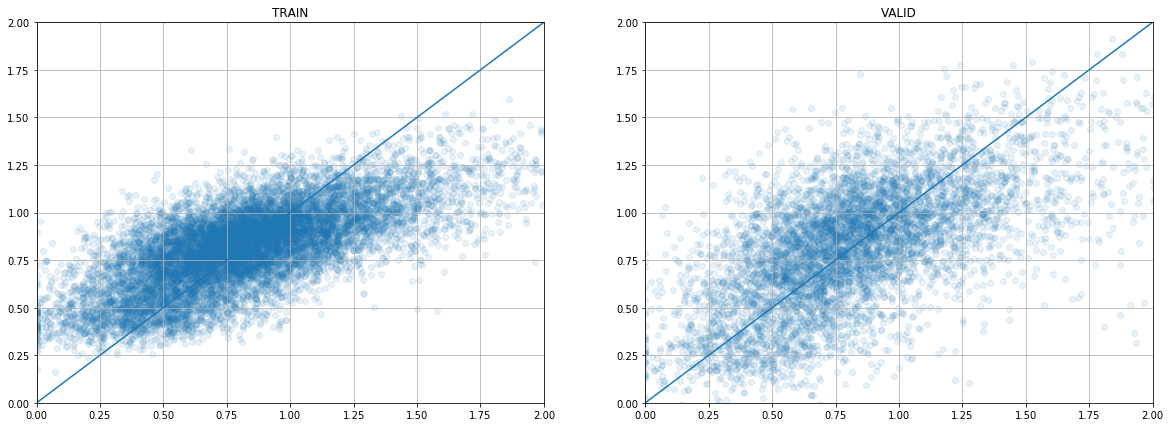

In [337]:
train_pred_y = model.predict(train_X[features])
valid_pred_y = model.predict(valid_X[features])

plt.figure(figsize=[20, 7])

plt.subplot(1, 2, 1)
plt.scatter(train_y, train_pred_y, alpha=0.1)
plt.plot([0, 2], [0, 2])
plt.title("TRAIN")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(valid_y, valid_pred_y * 1.5 - 0.4, alpha=0.1)
plt.plot([0, 2], [0, 2])
plt.title("VALID")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.grid()

In [341]:
np.sqrt(mean_squared_error(valid_y, valid_pred_y))

0.32223232528780027

In [308]:
train_X, train_y, test_X = ds.get_train_test_data()

In [309]:
model = xgb.XGBRegressor(
    max_depth=3, 
    learning_rate=0.01, 
    n_estimators=1000, 
    verbosity=0, 
    objective="reg:squarederror", 
    n_jobs=4,
)

In [310]:
model.fit(train_X[features], train_y)

/home/ivb/miniconda3/envs/ml/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

In [311]:
test_y = model.predict(test_X[features])

In [312]:
test_y

array([0.50520563, 0.46987513, 0.6881403 , ..., 0.8937963 , 0.91760314,
       0.58614695], dtype=float32)

In [313]:
ds.save_submission_pair("../data/xgb_8.csv", test_y)

In [314]:
Dataset.calc_score(1.05179, 1.03907)

(0.30488840942833917, 0.30491265485410357)